# Dependencies

In [1]:
# Memanggil Dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

from numpy import ndarray
from typing import List
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score, classification_report
from IPython.display import clear_output

RANDOM_SEED = 27

# Persiapan Data

## Load Dataset

In [2]:
# Load dataset
df = pd.read_csv('input/diabetesPreProcessed.csv')

# Mengambil data pada kolom Outcome ke variabel target sebagai numpy Array
dftarget = df['Outcome']
target = dftarget.to_numpy()

# Menghapus kolom Outcome untuk mengambil data seluruh features
df = df.drop(columns=['Outcome'])

# Seluruh data features disimpan ke dalam variabel data sebagai numpy Array
data = df.to_numpy()

## Data Transformation

In [3]:
# Standarisasi Data
from sklearn.preprocessing import StandardScaler
s = StandardScaler()
data = s.fit_transform(data)

## Data Splitting

In [4]:
# Split Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=RANDOM_SEED)

# Mengubah data target menjadi array 2D
y_train, y_test = y_train.reshape(-1, 1), y_test.reshape(-1, 1)

In [5]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(604, 8) (152, 8) (604, 1) (152, 1)


# Artificial Neural Network

## Fungsi-fungsi bantuan

In [6]:
# Fungsi-fungsi bantuan

def assert_same_shape(array: ndarray,
                      array_grad: ndarray):
    assert array.shape == array_grad.shape, \
        '''
        Kedua ndarray harus memiliki shape yang sama;
        Shape dari ndarray pertama adalah {0}
        dan shape dari ndarray kedua adalah {1}.
        '''.format(tuple(array_grad.shape), tuple(array.shape))
    
    return None

def permute_data(X, y):
    '''
    Permutasi acak urutan data dari input
    '''
    perm = np.random.permutation(X.shape[0])
    return X[perm], y[perm]

## Operation Class

In [7]:
class Operation(object):
    '''
    Kelas abstrak atau base class untuk tiap operasi yang ada di dalam neural network.
    '''
    def __init__(self):
        pass

    def forward(self, input_: ndarray):
        '''
        Menyimpan input ke dalam variabel self._input
        Kemudian memanggil fungsi self._output()
        '''
        self.input_ = input_

        self.output = self._output()

        return self.output


    def backward(self, output_grad: ndarray) -> ndarray:
        '''
        Memanggil fungsi self._input_grad()
        Memeriksa shape sesuai dengan yang seharusnya
        menggunakan fungsi bantuan assert_same_shape
        '''
        assert_same_shape(self.output, output_grad)

        self.input_grad = self._input_grad(output_grad)

        assert_same_shape(self.input_, self.input_grad)
        return self.input_grad


    def _output(self) -> ndarray:
        '''
        Fungsi _output didefinisikan dan disesuakan dalam setiap fungsi operasi masing-masing
        '''
        raise NotImplementedError()


    def _input_grad(self, output_grad: ndarray) -> ndarray:
        '''
        Fungsi _input_grad didefinisikan dan disesuakan dalam setiap fungsi operasi masing-masing
        '''
        raise NotImplementedError()

## ParamOperation Class

In [8]:
class ParamOperation(Operation):
    '''
    Kelas operasi dengan parameter.
    '''

    def __init__(self, param: ndarray) -> ndarray:
        super().__init__()
        self.param = param

    def backward(self, output_grad: ndarray) -> ndarray:
        '''
        Memanggil fungsi self._input_grad dan self._param_grad
        Juga memeriksa shape sesuai dengan yang seharusnya
        menggunakan fungsi bantuan assert_same_shape
        '''

        assert_same_shape(self.output, output_grad)

        self.input_grad = self._input_grad(output_grad)
        self.param_grad = self._param_grad(output_grad)

        assert_same_shape(self.input_, self.input_grad)
        assert_same_shape(self.param, self.param_grad)

        return self.input_grad

    def _param_grad(self, output_grad: ndarray) -> ndarray:
        '''
        Setiap subclass dari ParamOperation harus memiliki fungsi _param_grad
        '''
        raise NotImplementedError()

## Operasi-operasi spesifik
### Perkalian weight

In [9]:
class WeightMultiply(ParamOperation):
    '''
    Perkalian matriks dalam neural network
    '''

    def __init__(self, W: ndarray):
        '''
        inisisalisasi nilai self.param = W
        '''
        super().__init__(W)

    def _output(self) -> ndarray:
        '''
        Menghitung nilai Output
        '''
        return np.dot(self.input_, self.param)

    def _input_grad(self, output_grad: ndarray) -> ndarray:
        '''
        Menghitung nilai input gradient
        '''
        return np.dot(output_grad, np.transpose(self.param, (1, 0)))

    def _param_grad(self, output_grad: ndarray)  -> ndarray:
        '''
        Menghitung nilai parameter gradient
        '''        
        return np.dot(np.transpose(self.input_, (1, 0)), output_grad)

### Penambahan Bias

In [10]:
class BiasAdd(ParamOperation):
    '''
    Penghitungan proses penambahan bias
    '''

    def __init__(self,
                 B: ndarray):
        '''
        Inisialisasi operasi nilai self.param B
        Memastikan juga shape dari bias sesuai
        '''
        assert B.shape[0] == 1
        
        super().__init__(B)

    def _output(self) -> ndarray:
        '''
        Menghitung nilai output
        '''
        return self.input_ + self.param

    def _input_grad(self, output_grad: ndarray) -> ndarray:
        '''
        Menghitung nilai input gradient
        '''
        return np.ones_like(self.input_) * output_grad

    def _param_grad(self, output_grad: ndarray) -> ndarray:
        '''
        Menghitung nilai paramater gradient
        '''
        param_grad = np.ones_like(self.param) * output_grad
        return np.sum(param_grad, axis=0).reshape(1, param_grad.shape[1])

### Sigmoid

In [11]:
class Sigmoid(Operation):
    '''
    Fungsi aktivasi sigmoid
    '''

    def __init__(self) -> None:
        '''Pass'''
        super().__init__()

    def _output(self) -> ndarray:
        '''
        Menghitung nilai output
        '''
        return 1.0/(1.0+np.exp(-1.0 * self.input_))

    def _input_grad(self, output_grad: ndarray) -> ndarray:
        '''
        Menghitung input gradient
        '''
        sigmoid_backward = self.output * (1.0 - self.output)
        input_grad = sigmoid_backward * output_grad
        
        return input_grad

### ReLU

In [12]:
class ReLU(Operation):
    '''
    Fungsi aktivasi ReLU
    '''
    def __init__(self) -> None:
        super().__init__()

    def _output(self) -> ndarray:
        '''
        Menghitung nilai output
        '''
        return np.clip(self.input_, 0, None)

    def _input_grad(self, output_grad: ndarray) -> ndarray:
        '''
        Menghitung input gradient
        '''
        mask = self.output >= 0
        return output_grad * mask

### Linear

In [13]:
class Linear(Operation):
    '''
    Fungsi aktivasi linear
    '''

    def __init__(self) -> None:
        '''Pass'''        
        super().__init__()

    def _output(self) -> ndarray:
        '''Pass through'''
        return self.input_

    def _input_grad(self, output_grad: ndarray) -> ndarray:
        '''Pass through'''
        return output_grad

In [14]:
class Tanh(Operation):
    '''
    Hyperbolic tangent activation function
    '''
    def __init__(self) -> None:
        super().__init__()

    def _output(self) -> ndarray:
        return np.tanh(self.input_)

    def _input_grad(self, output_grad: ndarray) -> ndarray:

        return output_grad * (1 - self.output * self.output)

## Layer Class

In [15]:
class Layer(object):
    '''
    Layer neuron-neuron dalam Neural Network
    '''

    def __init__(self,
                 neurons: int):
        '''
        Init nilai neuron 
        '''
        self.neurons = neurons
        self.first = True
        self.params: List[ndarray] = []
        self.param_grads: List[ndarray] = []
        self.operations: List[Operation] = []

    def _setup_layer(self, num_in: int) -> None:
        '''
        Fungsi _setup_layer diimplementasikan pada setiap layer (Dense CLass)
        '''
        raise NotImplementedError()

    def forward(self, input_: ndarray) -> ndarray:
        '''
        Pass nilai input forward pada setiap operasi dalam layer
        ''' 
        if self.first:
            self._setup_layer(input_)
            self.first = False

        self.input_ = input_

        for operation in self.operations:

            input_ = operation.forward(input_)

        self.output = input_

        return self.output

    def backward(self, output_grad: ndarray) -> ndarray:
        '''
        Pass nilai output_grad backward pada setiap operasi dalam layer
        Assert cek nilai shape sesuai
        '''

        assert_same_shape(self.output, output_grad)

        for operation in reversed(self.operations):
            output_grad = operation.backward(output_grad)

        input_grad = output_grad
        
        self._param_grads()

        return input_grad

    def _param_grads(self) -> ndarray:
        '''
        Ekstrak nilai param_grads dari operasi yang ada pada layer
        '''

        self.param_grads = []
        for operation in self.operations:
            if issubclass(operation.__class__, ParamOperation):
                self.param_grads.append(operation.param_grad)

    def _params(self) -> ndarray:
        '''
        Ekstrak nilai _params dari operasi yang ada pada layer
        '''

        self.params = []
        for operation in self.operations:
            if issubclass(operation.__class__, ParamOperation):
                self.params.append(operation.param)

## Dense Class

In [16]:
class Dense(Layer):
    '''
    Fully connected layer, inherits dari Layer Class
    '''
    def __init__(self,
                 neurons: int,
                 activation: Operation = Sigmoid()):
        '''
        Mengatur fungsi aktivasi pada saat inisialisasi, 
        secara default akan menggunakan fungsi sigmoid
        '''
        super().__init__(neurons)
        self.activation = activation

    def _setup_layer(self, input_: ndarray) -> None:
        '''
        Setup kondisi layer, mengatur nilai awal weight, bias, dan 
        operasi yang terdapat dalam layer
        '''
        if self.seed:
            np.random.seed(self.seed)

        self.params = []

        # weights
        self.params.append(np.random.randn(input_.shape[1], self.neurons))

        # bias
        self.params.append(np.random.randn(1, self.neurons))
        
        # Operation
        self.operations = [WeightMultiply(self.params[0]),
                           BiasAdd(self.params[1]),
                           self.activation]

        return None

## Loss Class

In [17]:
class Loss(object):
    '''
    Base Class untuk penghitungan nilai Loss dari Neural Network
    '''

    def __init__(self):
        '''Pass'''
        pass

    def forward(self, prediction: ndarray, target: ndarray) -> float:
        '''
        Menghitung nilai loss
        '''
        assert_same_shape(prediction, target)

        self.prediction = prediction
        self.target = target

        loss_value = self._output()

        return loss_value

    def backward(self) -> ndarray:
        '''
        Menghitung nilai gradient loss terhadap input
        '''
        self.input_grad = self._input_grad()

        assert_same_shape(self.prediction, self.input_grad)

        return self.input_grad

    def _output(self) -> float:
        '''
        Setiap subclass dari Loss harus memiliki fungsi _output
        '''
        raise NotImplementedError()

    def _input_grad(self) -> ndarray:
        '''
        Setiap subclass dari Loss harus memiliki fungsi _input_grad
        '''
        raise NotImplementedError()

## Mean Squared Error

In [18]:
class MeanSquaredError(Loss):

    def __init__(self) -> None:
        '''Pass'''
        super().__init__()

    def _output(self) -> float:
        '''
        Menghitung nilai squared error loss
        '''
        loss = (
            np.sum(np.power(self.prediction - self.target, 2)) / 
            self.prediction.shape[0]
        )

        return loss

    def _input_grad(self) -> ndarray:
        '''
        Menghitung nilai gradient loss terhadap input
        '''        

        return 2.0 * (self.prediction - self.target) / self.prediction.shape[0]

## Neural Network Class

In [19]:
class NeuralNetwork(object):
    '''
    Class untuk Neural Network
    '''
    def __init__(self, 
                 layers: List[Layer],
                 loss: Loss,
                 seed: int = 1) -> None:
        '''
        Atribut-atribut yang dibutuhkan, yaitu layers dan loss
        '''
        self.layers = layers
        self.loss = loss
        self.seed = seed
        if seed:
            for layer in self.layers:
                setattr(layer, "seed", self.seed)        

    def forward(self, x_batch: ndarray) -> ndarray:
        '''
        Pass data forward melalui seluruh layer yang ada
        '''
        x_out = x_batch
        for layer in self.layers:
            x_out = layer.forward(x_out)

        return x_out

    def backward(self, loss_grad: ndarray) -> None:
        '''
        Pass data backward melalui seluruh layer yang ada
        '''

        grad = loss_grad
        for layer in reversed(self.layers):
            grad = layer.backward(grad)

        return None

    def train_batch(self,
                    x_batch: ndarray,
                    y_batch: ndarray) -> float:
        '''
        Fungsi batch training 
        Memanggil fungsi forward
        Hitung nilai Loss
        Memanggil fungsi backward
        '''
        
        predictions = self.forward(x_batch)

        loss = self.loss.forward(predictions, y_batch)

        self.backward(self.loss.backward())

        return loss
    
    def params(self):
        '''
        Get nilai seluruh parameter dari neural network
        '''
        for layer in self.layers:
            yield from layer.params

    def param_grads(self):
        '''
        Get nilai gradient loss terhadap parameters neural network.
        '''
        for layer in self.layers:
            yield from layer.param_grads    
            
    def getWeight(self, index):
        '''
        Get nilai weight dari atribut params berdasarkan indeks layer ke-n
        '''
        return self.layers[index].params[0]
    
    def getBias(self, index):
        '''
        Get nilai bias dari atribut params berdasarkan indeks layer ke-n
        '''
        return self.layers[index].params[1]

## Optimizer Class

In [20]:
class Optimizer(object):
    '''
    Base class untuk optimizer.
    '''
    def __init__(self,
                 lr: float = 0.01):
        '''
        Setiap optimizer harus memiliki inisiasi nilai learning rate.
        '''
        self.lr = lr

    def step(self) -> None:
        '''
        Setiap optimizer harus memiliki fungsi step.
        '''
        pass

### SGD

In [21]:
class SGD(Optimizer):
    '''
    Stochastic gradient descent optimizer.
    '''    
    def __init__(self,
                 lr: float = 0.01) -> None:
        '''Pass'''
        super().__init__(lr)

    def step(self):
        '''
        Menyesuaikan nilai parameter dengan besaran nilai penyesuaian 
        berdasarkan nilai learning rate.
        '''
        for (param, param_grad) in zip(self.net.params(),
                                       self.net.param_grads()):

            param -= self.lr * param_grad

## Trainer Class

In [22]:
from copy import deepcopy
from typing import Tuple

class Trainer(object):
    '''
    Melakukan training pada model neural network
    '''
    def __init__(self,
                 net: NeuralNetwork,
                 optim: Optimizer) -> None:
        '''
        Memasukkan objek neural network dan optimizer sebagai atribut dari trainer
        Kemudian mengatur objek neural network sebagai atribut dari optimizer
        '''
        self.net = net
        self.optim = optim
        self.best_loss = 1e9
        setattr(self.optim, 'net', self.net)
        
    def generate_batches(self,
                         X: ndarray,
                         y: ndarray,
                         size: int = 32) -> Tuple[ndarray]:
        '''
        Membuat beberapa batch untuk proses training
        Memastikan banyaknya baris data pada features dan juga target prediksi sama
        '''
        assert X.shape[0] == y.shape[0], \
        '''
        Banyaknya baris data pada features dan juga target prediksi harus sama
        sedangkan features memiliki {0} baris dan target memiliki {1} baris
        '''.format(X.shape[0], y.shape[0])

        N = X.shape[0]

        for ii in range(0, N, size):
            X_batch, y_batch = X[ii:ii+size], y[ii:ii+size]

            yield X_batch, y_batch

            
    def fit(self, X_train: ndarray, y_train: ndarray,
            X_test: ndarray, y_test: ndarray,
            epochs: int=100,
            eval_every: int=10,
            batch_size: int=32,
            seed: int = 1,
            restart: bool = True)-> None:
        '''
        Fit model neural network terhadap set data training sebanyak epoch yang telah ditentukan.
        "eval_every" merupakan variabel yang digunakan untuk mengatur setiap berapa epoch model
        akan dievaluasi, evaluasi dilakukan menggunakan set data testing.
        '''

        np.random.seed(seed)
        if restart:
            for layer in self.net.layers:
                layer.first = True

            self.best_loss = 1e9

        for e in range(epochs):

            if (e+1) % eval_every == 0:
                # Menyimpan data model terakhir ke "last_model" apabila proses training 
                # berhenti lebih dulu karena hasil evaluasi nilai loss naik
                last_model = deepcopy(self.net)

            X_train, y_train = permute_data(X_train, y_train)

            batch_generator = self.generate_batches(X_train, y_train,
                                                    batch_size)

            for ii, (X_batch, y_batch) in enumerate(batch_generator):

                self.net.train_batch(X_batch, y_batch)

                self.optim.step()

            if (e+1) % eval_every == 0:

                test_preds = self.net.forward(X_test)
                loss = self.net.loss.forward(test_preds, y_test)
                
                # Jika nilai loss tetap menurun maka proses training terus lanjut
                # Namun jika nilai loss naik, maka proses akan berhenti
                if loss < self.best_loss:
#                     print(f"Validation loss after {e+1} epochs is {loss:.3f}")
                    self.best_loss = loss
                else:
                    print(f"""Loss increased after epoch {e+1}, final loss was {self.best_loss:.3f}, using the model from epoch {e+1-eval_every}""")
                    self.net = last_model
                    setattr(self.optim, 'net', self.net)
                    break

## Evaluation Metrics

In [23]:
def eval_classification(model: NeuralNetwork,
                          X_test: ndarray,
                          y_test: ndarray):
    '''
    Generate hasil prediksi classification dari model 
    menggunakan set data testing
    '''
    regressionPreds = model.forward(X_test)
    regressionPreds = regressionPreds.reshape(-1, 1)
    
    classsificationPreds = np.array([])

    for i in regressionPreds:
        if i < 0.5:
            classsificationPreds = np.append(classsificationPreds, [0])
        else:
            classsificationPreds = np.append(classsificationPreds, [1])
            
    return classsificationPreds

# Evolving Algorithm
## Fungsi-fungsi bantuan

In [24]:
def neuronRandom(neuronList):
    '''
    Memilih jumlah N neuron dari NeuronList
    ''' 
    return (random.choice(neuronList))


def activationRandom(activationList):
    '''
    Memilih fungsi aktivasi yang akan digunakan dari ActivationList
    ''' 
    return (random.choice(activationList))

def lrRandom():
    '''
    Mendapatkan nilai acak antara 0.01 s.d. 0.2 untuk learning rate
    '''
    return round(random.uniform(0.01, 0.2), 2)

def modelGenerator():
    '''
    Membuat / Generate model sebagai gen baru
    ''' 
    nn = NeuralNetwork(layers=[Dense(neurons=neuronRandom(neuronList), activation=activationRandom(activationList)), 
                               Dense(neurons=1, activation=Sigmoid())], 
                       loss=MeanSquaredError(), 
                       seed=RANDOM_SEED)
    return nn

def calculateFitness(gen):
    '''
    Menghitung nilai fitness dari gen menggunakan metric accuracy
    Argumen gen merupakan objek model neural network
    ''' 
    testPreds = eval_classification(gen, X_test, y_test)
    testAccuracy = (accuracy_score(testPreds, y_test))
    
    return testAccuracy

## Fungsi Membuat Populasi

In [25]:
def createPopulation(nPopulation):
    '''
    Membuat populasi sebanyak nPopulation
    ''' 
    population = dict([('gen', []),
                       ('lr', []),
                       ('trainer', []),
                       ('fitness', [])])
    
    # Looping sebanyak nPopulation
    for i in range (nPopulation): 
        
        # Membuat gen baru dan menambahkannya ke dalam dict
        newGen = modelGenerator()
        population['gen'].append(newGen)
        
        # Mengacak nilai lr dan menambahkannya ke dalam dict
        lrRand = lrRandom()
        population['lr'].append(lrRand)
        
        # Membuat trainer berdasarkan gen model yang telah dibuat dan nilai lr yang telah diacak
        trainer = Trainer(newGen, SGD(lr=lrRand))
        
        # Melakukan fitting dari trainer yang telah dibuat
        trainer.fit(X_train, y_train, X_test, y_test,
        epochs = maxEpochs,
        eval_every = 1,
        seed=RANDOM_SEED)
        
        # Memasukkan trainer ke dalam dict
        population['trainer'].append(trainer)
        
        # Menghitung dan memasukkan nilai fitness dari gen yang telah di fitting
        fitness = calculateFitness(newGen)
        population['fitness'].append(fitness)

    return population

## Fungsi Seleksi

In [26]:
def selection(population):
    '''
    Melakukan seleksi dari performa gen yang ada di dalam populasi
    ''' 
    parent1 = dict([('gen', []), ('lr', []), ('trainer', []), ('fitness', [])])
    parent2 = dict([('gen', []), ('lr', []), ('trainer', []), ('fitness', [])])
    
    # Cari index dari data populasi dengan nilai fitness terbesar
    max_index = np.argmax(np.asarray(population['fitness']), axis=0)
    
    #  Simpan data tersebut sebagai parent1
    parent1['gen'] = population['gen'][max_index]
    parent1['lr'] = population['lr'][max_index]
    parent1['trainer'] = population['trainer'][max_index]
    parent1['fitness'] = population['fitness'][max_index]
    
    # Simpan data tertinggi ke tmp, untuk di pop terlebih dahulu
    tmp_index = max_index
    tmp_gen = population['gen'][max_index]
    tmp_lr = population['lr'][max_index]
    tmp_trainer = population['trainer'][max_index]
    tmp_fitness = population['fitness'][max_index]
    
    # Pop data tertinggi untuk proses mencari data tertinggi ke 2
    population['gen'].pop(max_index)
    population['lr'].pop(max_index)
    population['trainer'].pop(max_index)
    population['fitness'].pop(max_index)
    
    # Cari index dari data dengan fitness tertinggi ke 2
    max_index = np.argmax(np.asarray(population['fitness']), axis=0)
    
    #  Simpan sebagai parent2
    parent2['gen'] = population['gen'][max_index]
    parent2['lr'] = population['lr'][max_index]
    parent2['trainer'] = population['trainer'][max_index]
    parent2['fitness'] = population['fitness'][max_index]
    
    # Kembalikan data di tmp ke populasi di index tmp
    population['gen'].insert(tmp_index, tmp_gen)
    population['lr'].insert(tmp_index, tmp_lr)
    population['trainer'].insert(tmp_index, tmp_trainer)
    population['fitness'].insert(tmp_index, tmp_fitness)
    
    print("parent1: ", parent1['gen'].layers[0].neurons, parent1['lr'], parent1['fitness'], parent1['gen'].layers[0].activation)
    print("parent2: ", parent2['gen'].layers[0].neurons, parent2['lr'], parent2['fitness'], parent2['gen'].layers[0].activation)
    return [parent1, parent2]

## Fungsi Crossover

In [27]:
def crossover(parents):
    '''
    Melakukan crossover dari parents untuk membuat child
    ''' 
    child1 = dict([('gen', []), ('lr', []), ('trainer', []), ('fitness', [])])
    child2 = dict([('gen', []), ('lr', []), ('trainer', []), ('fitness', [])])
    
    # status untuk menandakan kondisi banyaknya neuron dari hidden layer milik parent
    # crossoverStatus bernilai 0 jika banyaknya neuron dari kedua parent berbeda    
    crossoverStatus = 0
    
    # Proses ketika banyaknya neuron dari kedua parent sama
    if parents[0]['gen'].layers[0].neurons == parents[1]['gen'].layers[0].neurons:
        # crossoverStatus bernilai 1 jika banyaknya neuron dari kedua parent sama
        crossoverStatus = 1
        
        # Data dari kedua parent dimasukkan ke dalam dict child
        child1['gen'] = deepcopy(parents[0]['gen'])
        child2['gen'] = deepcopy(parents[1]['gen'])
        
        # Ambil length dari array features milik input dengan shape 
        # kemudian bagi 2 nilai tersebut untuk memecah array weight menjadi 2 bagian
        # simpan nilai ke Crossover Point (CP)
        CP = parents[0]['gen'].layers[0].params[0].shape[0] // 2
        
        # Nilai weight dari child1 adalah setengah nilai weight awal dari parent[0]
        # dan setengah nilai weight akhir dari parent[1]
        child1Weights = np.concatenate((parents[0]['gen'].layers[0].params[0][:CP], 
                                        parents[1]['gen'].layers[0].params[0][CP:]),axis = 0)
        
        # Nilai weight dari child2 adalah setengah nilai weight awal dari parent[1]
        # dan setengan nilai weight akhir dari parent[0]
        child2Weights = np.concatenate((parents[1]['gen'].layers[0].params[0][:CP],
                                        parents[0]['gen'].layers[0].params[0][CP:]),axis = 0)
        
        
        # Ambil length dari array bias (sama seperti jumlah neurons di hidden layer)
        # kemudian bagi 2 nilai tersebut untuk memecah array bias menjadi 2 bagian
        # simpan nilai ke Crossover Point (CP)
        CP = parents[0]['gen'].layers[0].params[1].shape[1] // 2
        
        # Nilai bias dari child1 adalah setengah nilai bias awal dari parent[0]
        # dan setengah nilai bias akhir dari parent[1]
        bias = np.concatenate((parents[0]['gen'].layers[0].params[1][0][:CP], 
                               parents[1]['gen'].layers[0].params[1][0][CP:]),axis = 0)
        child1Bias = np.array([bias])

        # Nilai bias dari child2 adalah setengah nilai bias awal dari parent[1]
        # dan setengah nilai bias akhir dari parent[0]
        bias = np.concatenate((parents[1]['gen'].layers[0].params[1][0][:CP],
                                parents[0]['gen'].layers[0].params[1][0][CP:]),axis = 0)
        child2Bias = np.array([bias])
        
        # Masukkan nilai weight dan bias ke child1
        child1['gen'].layers[0].params[0] = child1Weights
        child1['gen'].layers[0].params[1] = child1Bias
        
        # Masukkan nilai weight dan bias ke child2
        child2['gen'].layers[0].params[0] = child2Weights
        child2['gen'].layers[0].params[1] = child2Bias
        
        # Fungsi aktivasi dan Learning rate child1 milik parent[1]
        child1['gen'].layers[0].activation = parents[1]['gen'].layers[0].activation        
        child1['lr'] = parents[1]['lr']
        child1['trainer'] = Trainer(child1['gen'], SGD(lr=child1['lr']))
        
        # Fungsi aktivasi dan Learning rate child2 milik parent[0]
        child2['gen'].layers[0].activation = parents[0]['gen'].layers[0].activation
        child2['lr'] = parents[0]['lr']
        child2['trainer'] = Trainer(child2['gen'], SGD(lr=child2['lr']))
        
        
        # Hitung kembali fitness kedua child setelah crossover
        child1['fitness'] = calculateFitness(child1['gen'])
        child2['fitness'] = calculateFitness(child2['gen'])
        
    # Proses ketika banyaknya neuron dari kedua parent tidak sama
    # Tidak ada penyilangan weight dan bias, karena shape keduanya berbeda
    else:
        
        # Fungsi aktivasi dan Learning rate child1 milik parent[1]
        child1['gen'] = deepcopy(parents[0]['gen'])
        child1['gen'].layers[0].activation = parents[1]['gen'].layers[0].activation
        child1['lr'] = parents[1]['lr']
        child1['trainer'] = Trainer(child1['gen'], SGD(lr=child1['lr']))
        
        # Fungsi aktivasi dan Learning rate child1 milik parent[0]
        child2['gen'] = deepcopy(parents[1]['gen'])
        child2['gen'].layers[0].activation = parents[0]['gen'].layers[0].activation
        child2['lr'] = parents[0]['lr']
        child2['trainer'] = Trainer(child2['gen'], SGD(lr=child2['lr']))
        
        # Hitung kembali fitness kedua child setelah crossover
        child2['fitness'] = calculateFitness(child2['gen'])
        child1['fitness'] = calculateFitness(child1['gen'])
    
    print("child1: ", child1['gen'].layers[0].neurons, child1['lr'], child1['fitness'], child1['gen'].layers[0].activation)
    print("child2: ", child2['gen'].layers[0].neurons, child2['lr'], child2['fitness'], child2['gen'].layers[0].activation)
    return [child1, child2, crossoverStatus]

## Fungsi Mutasi

In [28]:
def mutation(child, mutationRate):
    '''
    Proses mutasi kedua child yang dihasilkan dari proses crossover
    ''' 
    # Tambah key baru mutationLog ke dalam dict mutant 
    # untuk mencatat mutasi apa saja yang terjadi dalam fungsi ini
    mutant1 = child[0]
    mutant1['mutationLog'] = dict([('neuronUpdated', 0), ('activationUpdated', 0), ('lrUpdated', 0)])
    mutant2 = child[1]
    mutant2['mutationLog'] = dict([('neuronUpdated', 0), ('activationUpdated', 0), ('lrUpdated', 0)])
    
    # Jadikan data kedua mutant sebagai list
    mutants = [mutant1, mutant2]
    
    # Loop kedua Mutant dalam list untuk proses mutasi
    for i in range(2):
        '''
        mutationRate adalah ambang batas kemungkinan untuk terjadinya mutasi pada mutant
        
        Dihasilkan nilai acak antara 0 dan 1, kemudian mutasi akan terjadi apabila
        nilai random yang dihasilkan lebih kecil dari mutationRate
        
        Sehingga probabilitas terjadinya mutasi akan lebih besar apabila
        nilai dari mutationRate semakin besar
        ''' 
        # Mutasi banyaknya neuron dengan mengambil banyaknya neuron dari neuronList
        if random.random() <= mutationRate:
            mutants[i]['gen'].layers[0].neurons = neuronRandom(neuronList)
            mutants[i]['mutationLog']['neuronUpdated'] = 1
            
        # Mutasi fungsi aktivasi dengan mengambil dari activationList
        if random.random() <= mutationRate:
            randDifStatus = True
            while randDifStatus == True:
                actRand = activationRandom(activationList)
                # print("actRand", actRand) 
                # print("mutAct", mutants[i]['gen'].layers[0].activation)
                if actRand != mutants[i]['gen'].layers[0].activation:
                    mutants[i]['gen'].layers[0].activation = actRand
                    randDifStatus = False
                    mutants[i]['mutationLog']['activationUpdated'] = 1
                    # print(f"mutasi aktivasi {i}", mutants[i]['gen'].layers[0].activation)
        
        # Mutasi Learning Rate dengan fungsi bantuan lrRandom
        if random.random() <= mutationRate:
            mutants[i]['lr'] = lrRandom()
            mutants[i]['mutationLog']['lrUpdated'] = 1
            
        # Memasukkan trainer baru berdasarkan atribut yang dimiliki
        # kemudian fitting mutant dan hitung nilai fitness-nya
        mutants[i]['trainer'] = Trainer(mutants[i]['gen'], SGD(lr=mutants[i]['lr']))
        mutants[i]['trainer'].fit(X_train, y_train, X_test, y_test,
                                 epochs = maxEpochs,
                                 eval_every = 1,
                                 seed=RANDOM_SEED)
        mutants[i]['fitness'] = calculateFitness(mutants[i]['gen'])
    
    print("mutant1: ", mutants[0]['gen'].layers[0].neurons, mutants[0]['lr'], mutants[0]['fitness'], mutants[0]['gen'].layers[0].activation)
    print("mutant2: ", mutants[1]['gen'].layers[0].neurons, mutants[1]['lr'], mutants[1]['fitness'], mutants[1]['gen'].layers[0].activation)
    return mutants

## Fungsi Regenerasi

In [29]:
def regeneration(mutants, population):
    '''
    Proses regenerasi untuk menghapus gen dengan fitness terkecil di dalam populasi
    Kemudian memasukkan mutant baru yang dihasilkan dari proses mutasi
    ''' 
    # Loop kedua mutant
    for i in range(2):
        # Cari index dari data populasi dengan fitness terkecil
        min_index = np.argmin(np.asarray(population['fitness']), axis=0)
        
        # Jika data dengan fitness terkecil dari populasi lebih kecil dari fitness mutant
#         if population['fitness'][min_index] < mutants[i]['fitness']:
        # Maka gen populasi tersebut dihapus
        population['gen'].pop(min_index)
        population['lr'].pop(min_index)
        population['trainer'].pop(min_index)
        population['fitness'].pop(min_index)

        # Kemudian menambah populasi dengan data mutant baru
        population['gen'].append(mutants[i]['gen'])
        population['lr'].append(mutants[i]['lr'])
        population['trainer'].append(mutants[i]['trainer'])
        population['fitness'].append(mutants[i]['fitness'])

    return population

## Fungsi Terminasi

In [30]:
def termination(population, fitnessTarget, generation, nGeneration):
    
    # Cari index dari data dengan fitness tertinggi
    max_index = np.argmax(np.asarray(population['fitness']), axis=0)
    
    # Cek apakah nilai fitness terbaik di dalam populasi sudah mencapai fitness target
    if population['fitness'][max_index] > fitnessTarget:
        # Jika sudah tercapai maka ubah isLooping menjadi False
        isLooping = False        
        
    else:
        # Jika belum tercapai maka isLooping tetap True
        isLooping = True
    
    # Cek juga apakah proses evolusi sudah mencapai batas maksimum generasi
    if generation >= nGeneration:
        # Jika sudah tercapai maka ubah isGenerating menjadi False
        isGenerating = False
        
    else:
        # Jika belum tercapai maka isGenerating tetap True
        isGenerating = True

    # return variabel solusi
    return {'max_index':max_index, 'isLooping':isLooping, 'isGenerating':isGenerating}

# Pelatihan dan Pengujian Algoritma

## Inisiasi variabel konfigurasi

In [31]:
neuronList = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]
activationList = [Sigmoid(), ReLU(), Linear(), Tanh()]
maxEpochs = 2000

nPopulation = 10
nGeneration = 100
mutationRate = 0.5

fitnessTarget = 0.85
isLooping = True
isGenerating = True

random.seed(RANDOM_SEED)

## Pelatihan

In [32]:
%%time
import time

print(f"Inisiasi {nPopulation} Populasi Awal...")
population = createPopulation(nPopulation)

generation = 1
while isLooping and isGenerating:
    # Membersihkan output dari generasi sebelumnya pada console jupyter notebook
    clear_output(wait=True)
    
    # Memeriksa populasi dengan fungsi terminasi
    solution = termination(population, fitnessTarget, generation, nGeneration)
    
    # Update nilai parameter kondisi while berdasarkan output fungsi terminasi
    isLooping = solution['isLooping']
    isGenerating = solution['isGenerating']
    
    # Ambil nilai index dari gen terbaik pada generasi ke-i
    max_index = solution['max_index']
    
    # Output atribut-atribut dari gen terbaik
    print("Generasi ke: ")
    print(generation)
    print()
    print("Data Gen Terbaik")
    print("Indeks: ")
    print(max_index)
    print()
    
    print("Banyaknya Neuron: ")
    print(population['gen'][max_index].layers[0].neurons)
    print()
    
    print("Learning rate: ")
    print(population['lr'][max_index])
    print()
    
    print("Fungsi Aktivasi: ")
    print(population['gen'][max_index].layers[0].activation)
    print()
    
    print("Fitness: ")
    print(population['fitness'][max_index])
    print()
    
    print("========")
    
    # Memulai proses evolusi pada populasi
    print("Proses: ")
    
    # Melakukan seleksi
    print("Seleksi...")
    parents = selection(population)
    
    # Melakukan crossover
    print("Crossover...")
    childs = crossover(parents)
    
    # Melakukan mutasi
    print("Mutasi...")
    mutants = mutation(childs, mutationRate)
    
    # Melakukam regenerasi
    print("Regenerasi...")
    population = regeneration(mutants, population)
    print()
    
    print("========")
    print()
    
    # Iterasi generasi
    generation += 1
        
# Cek berhentinya proses evolusi
if not isLooping:
    # Jika karena target nilai fitness tercapai
    print("Fitness Target Tercapai")
    
if not isGenerating:
    # Jika karena generasi maksimum telah tercapai
    print("Generasi Maksimum Tercapai")

Generasi ke: 
100

Data Gen Terbaik
Indeks: 
7

Banyaknya Neuron: 
16

Learning rate: 
0.02

Fungsi Aktivasi: 

Fitness: 
0.8355263157894737

Proses: 
Seleksi...
parent1:  16 0.02 0.8355263157894737 <__main__.Tanh object at 0x0000019CDDF32A88>
parent2:  32 0.04 0.8092105263157895 <__main__.Tanh object at 0x0000019CDDF32A88>
Crossover...
child1:  16 0.04 0.8355263157894737 <__main__.Tanh object at 0x0000019CDDF32A88>
child2:  32 0.02 0.8092105263157895 <__main__.Tanh object at 0x0000019CDDF32A88>
Mutasi...
Loss increased after epoch 74, final loss was 0.190, using the model from epoch 73
Loss increased after epoch 87, final loss was 0.168, using the model from epoch 86
mutant1:  16 0.04 0.7763157894736842 <__main__.ReLU object at 0x0000019CDDF32D48>
mutant2:  32 0.16 0.7960526315789473 <__main__.Tanh object at 0x0000019CDDF32A88>
Regenerasi...


Generasi Maksimum Tercapai
Wall time: 6min 32s


### Pengukuran Performa

Confusion Matrix:
[[89 16]
 [ 9 38]]
              precision    recall  f1-score   support

           0       0.91      0.85      0.88       105
           1       0.70      0.81      0.75        47

    accuracy                           0.84       152
   macro avg       0.81      0.83      0.81       152
weighted avg       0.84      0.84      0.84       152



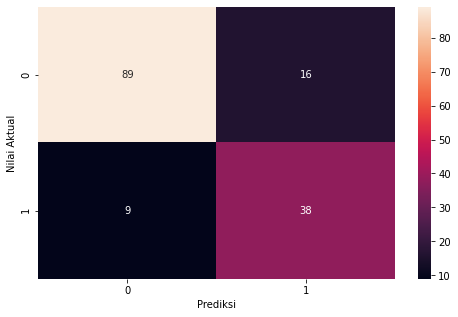

In [33]:
print("Confusion Matrix:")
y_pred = eval_classification(population['gen'][max_index], X_test, y_test)
cm = confusion_matrix(y_test, y_pred) 
print(cm)

print(classification_report(y_test, y_pred))
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cm, annot=True, fmt=".0f", ax=ax)
plt.xlabel("Prediksi")
plt.ylabel("Nilai Aktual")
plt.show()

### Menyimpan Output

In [34]:
# Menyimpan nilai output bernilai riil
np.savetxt('output/output0.txt', population['gen'][max_index].layers[1].output, delimiter=',', fmt='%1.5f')

# Menyimpan nilai output Prediksi akhir
testPreds = eval_classification(population['gen'][max_index], X_test, y_test)
np.savetxt('output/output1.txt', testPreds, delimiter=',', fmt='%i')

# Menyimpan nilai weight dan bias pada layer 0 (hidden layer)
weights0 = population['gen'][max_index].layers[0].params[0]
bias0 = population['gen'][max_index].layers[0].params[1]
np.savetxt('output/weights0.txt', weights0, delimiter=',')
np.savetxt('output/bias0.txt', bias0, delimiter=',')

# Menyimpan nilai weight dan bias pada layer 1 (output layer)
weights1 = population['gen'][max_index].layers[1].params[0]
bias1 = population['gen'][max_index].layers[1].params[1]
np.savetxt('output/weights1.txt', weights1, delimiter=',')
np.savetxt('output/bias1.txt', bias1, delimiter=',')